### **LAB #5 - Redes Neuronales Recurrentes (RNN) para Series de Tiempo**

- Derek Arreaga - 22537
- Mónica Salvatierra

Link del repositorio: https://github.com/alee2602/LAB5-DS



### **Importación de Librerías**

In [14]:

import os, sys, math, warnings, json, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pandas_datareader import data as pdr

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers


# Semillas para reproducibilidad
SEED = 8
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


### **1. Carga y exploración de datos**

Descarga exitosa desde FRED: IPN31152N  |  filas=486  rango=1985-01-01..2025-06-01


,value
date,
1985-01-01,76.4150
1985-02-01,86.8838
1985-03-01,101.5509


,value
date,
2025-04-01,116.9527
2025-05-01,118.2192
2025-06-01,127.0128


       count        mean       std      min       25%       50%         75%  \
value  486.0  118.226987  24.82883  68.0609  100.4178  116.6211  133.038675   

            max  
value  196.8174  

Frecuencia inferida: MS


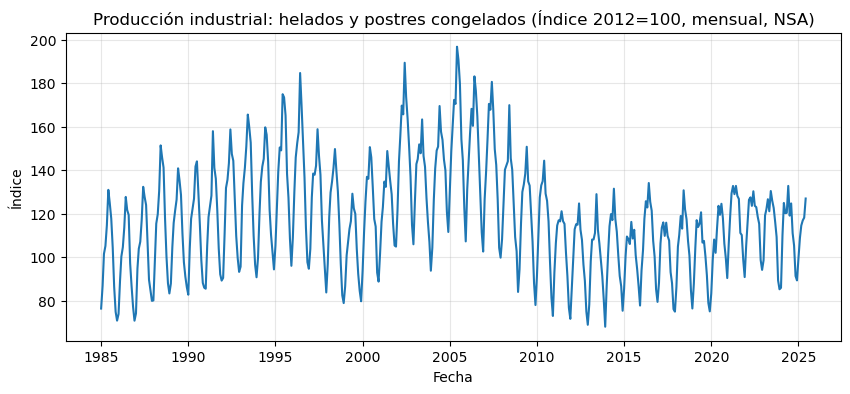

In [9]:
SERIE = "IPN31152N"  # Ice cream & frozen dessert production index (2012=100, mensual, NSA)
START = "1985-01-01" # fecha inicial amplia para historia
END   = None         # hasta hoy

def load_fred_series(serie=SERIE, start=START, end=END):
    try:
        df = pdr.DataReader(serie, "fred", start=start, end=end)
        df = df.rename(columns={serie: "value"})
        df.index.name = "date"
        print(f"Descarga exitosa desde FRED: {serie}  |  filas={len(df)}  rango={df.index.min().date()}..{df.index.max().date()}")
        return df
    except Exception as e:
        print("No se pudo descargar desde FRED. Intentando CSV local...", e)
        # CSV de respaldo en el mismo folder del notebook
        local = f"./{serie}.csv"
        if not os.path.exists(local):
            raise FileNotFoundError(f"No hay internet ni archivo local '{local}'. Coloca un CSV con columnas DATE,VALUE.")
        df = pd.read_csv(local)
        # normaliza columnas
        cols = {c.lower(): c for c in df.columns}
        date_col = cols.get("date", None)
        value_col = cols.get("value", None)
        if date_col is None or value_col is None:

            date_col = "DATE" if "DATE" in df.columns else list(df.columns)[0]
            value_col = "VALUE" if "VALUE" in df.columns else list(df.columns)[1]
        df = df.rename(columns={date_col: "date", value_col: "value"})
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date").sort_index()
        print(f"Carga local desde CSV: {local} | filas={len(df)}  rango={df.index.min().date()}..{df.index.max().date()}")
        return df

df = load_fred_series()
display(df.head(3))
display(df.tail(3))


print(df.describe().T)
print("\nFrecuencia inferida:", pd.infer_freq(df.index))


plt.figure(figsize=(10,4))
plt.plot(df.index, df["value"], lw=1.5)
plt.title("Producción industrial: helados y postres congelados (Índice 2012=100, mensual, NSA)")
plt.xlabel("Fecha"); plt.ylabel("Índice")
plt.grid(True, alpha=0.3)
plt.show()


### **2. División de conjuntos**

In [ ]:

test_months = 24

# Asegurarnos de que el índice esté ordenado y con frecuencia mensual
df = df.sort_index()
if pd.infer_freq(df.index) is None:
    # Si la frecuencia no se infiere, reindexamos a meses 
    df = df.asfreq('MS')  

n_total = len(df)
n_test = test_months
n_train = n_total - n_test

train = df.iloc[:n_train].copy()
test  = df.iloc[n_train:].copy()

print(f"Filas totales: {n_total}, Entrenamiento: {len(train)}, Prueba: {len(test)}")
print("Rango train:", train.index.min().date(), "->", train.index.max().date())
print("Rango test :", test.index.min().date(), "->", test.index.max().date())

Filas totales: 486, Entrenamiento: 462, Prueba: 24
Rango train: 1985-01-01 -> 2023-06-01
Rango test : 2023-07-01 -> 2025-06-01


### **3. Normalización y preparación**

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
train_vals = train['value'].values.reshape(-1,1)
test_vals  = test['value'].values.reshape(-1,1)

scaler.fit(train_vals)                 # ajustar solo con datos de entrenamiento
train_scaled = scaler.transform(train_vals)
test_scaled  = scaler.transform(test_vals)

# Parametrización del generador de secuencias (lookback)
lookback = 12      
batch_size = 32

train_gen = TimeseriesGenerator(train_scaled, train_scaled,
                                length=lookback, sampling_rate=1, stride=1,
                                batch_size=batch_size)

# Para evaluación/predicción, creamos un generador que permita predecir sobre la ventana de test:
combined = np.vstack([train_scaled[-lookback:], test_scaled])  
test_gen = TimeseriesGenerator(combined, combined,
                            length=lookback, batch_size=1)

print("Ejemplos en train_gen:", len(train_gen))
print("Ejemplos en test_gen :", len(test_gen))
print("shape ejemplo X:", train_gen[0][0].shape, "y shape:", train_gen[0][1].shape)


Ejemplos en train_gen: 15
Ejemplos en test_gen : 24
shape ejemplo X: (32, 12, 1) y shape: (32, 1)


### **4. Construcción del modelo**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# 1 LSTM con return_sequences=False, capa densa final
model_lstm = models.Sequential([
    layers.Input(shape=(lookback, 1)),
    layers.LSTM(64, activation='tanh', return_sequences=False,
                kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.1),
    layers.Dense(1, activation='linear')
])

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='mse',
                   metrics=['mae'])

model_lstm.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


### **5. Entrenamiento y evaluación**

In [ ]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
ck = callbacks.ModelCheckpoint('best_lstm.keras', monitor='val_loss', save_best_only=True)

# Preparar validación: usar 10% del train para validación durante fit
history_lstm = model_lstm.fit(
    train_gen,
    epochs=200,                # se detendrá por EarlyStopping si no mejora
    validation_data=None,      
    batch_size=None,           
    callbacks=[es, ck],
    verbose=2
)

# Guardar tiempo y resultados
print("Entrenamiento finalizado. Épocas entrenadas:", len(history_lstm.history['loss']))


Epoch 1/200
15/15 - 3s - loss: 0.0782 - mae: 0.2202 - 3s/epoch - 196ms/step
Epoch 2/200
15/15 - 0s - loss: 0.0420 - mae: 0.1567 - 122ms/epoch - 8ms/step
Epoch 3/200
15/15 - 0s - loss: 0.0375 - mae: 0.1501 - 135ms/epoch - 9ms/step
Epoch 4/200
15/15 - 0s - loss: 0.0340 - mae: 0.1417 - 127ms/epoch - 8ms/step
Epoch 5/200
15/15 - 0s - loss: 0.0333 - mae: 0.1408 - 124ms/epoch - 8ms/step
Epoch 6/200
15/15 - 0s - loss: 0.0339 - mae: 0.1408 - 134ms/epoch - 9ms/step
Epoch 7/200
15/15 - 0s - loss: 0.0328 - mae: 0.1405 - 118ms/epoch - 8ms/step
Epoch 8/200
15/15 - 0s - loss: 0.0320 - mae: 0.1368 - 144ms/epoch - 10ms/step
Epoch 9/200
15/15 - 0s - loss: 0.0327 - mae: 0.1387 - 130ms/epoch - 9ms/step
Epoch 10/200
15/15 - 0s - loss: 0.0282 - mae: 0.1279 - 129ms/epoch - 9ms/step
Epoch 11/200
15/15 - 0s - loss: 0.0286 - mae: 0.1301 - 127ms/epoch - 8ms/step
Epoch 12/200
15/15 - 0s - loss: 0.0264 - mae: 0.1222 - 113ms/epoch - 8ms/step
Epoch 13/200
15/15 - 0s - loss: 0.0239 - mae: 0.1147 - 113ms/epoch - 8ms/

In [ ]:
# Cargar mejor modelo si existe
try:
    model_lstm = models.load_model('best_lstm.keras')
    print("Modelo restaurado desde checkpoint.")
except Exception:
    print("Usando modelo entrenado en memoria.")

# Predecir todo el conjunto combinado a partir del test_gen
pred_scaled = model_lstm.predict(test_gen, verbose=0)
pred_scaled = pred_scaled.reshape(-1,1)

# Solo tomar las predicciones correspondientes al periodo de test (len(test) valores)
pred_test_scaled = pred_scaled[:len(test)]
pred_test = scaler.inverse_transform(pred_test_scaled)

# Series para comparar
pred_index = test.index
pred_series = pd.Series(pred_test.flatten(), index=pred_index, name='pred')
actual_series = test['value']

# Mostrar primeras predicciones
display(pd.DataFrame({"actual": actual_series.values.flatten(), "pred": pred_series.values.flatten()}).head())


Usando modelo entrenado en memoria.


,actual,pred
0,126.0569,127.366661
1,122.6748,122.362015
2,116.2177,115.799820
3,109.3279,107.806320
4,89.3353,101.253929


### **6. Resultados**

MAE: 4.9406, RMSE: 6.0097


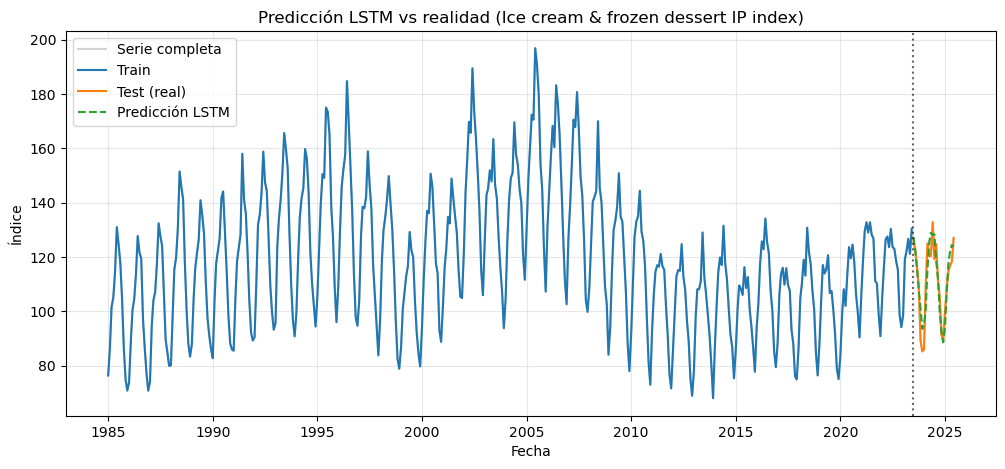

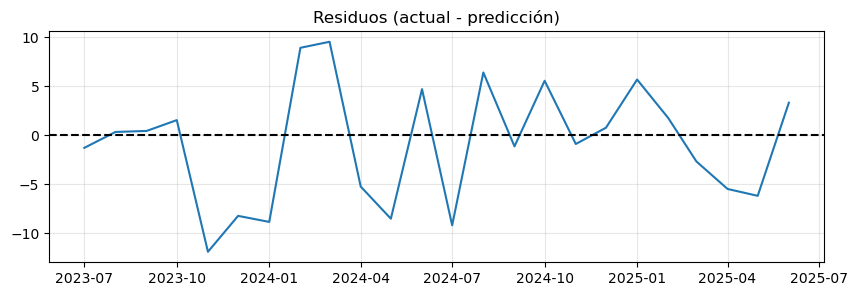

In [20]:
# Métricas
mae = mean_absolute_error(actual_series, pred_series)
rmse = math.sqrt(mean_squared_error(actual_series, pred_series))
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Gráfica: serie real vs predicción
plt.figure(figsize=(12,5))
plt.plot(df.index, df['value'], label='Serie completa', color='lightgray')
plt.plot(train.index, train['value'], label='Train', color='tab:blue')
plt.plot(test.index, test['value'], label='Test (real)', color='tab:orange')
plt.plot(pred_series.index, pred_series.values, label='Predicción LSTM', color='tab:green', linestyle='--')
plt.axvline(test.index[0], color='k', linestyle=':', alpha=0.6)
plt.legend()
plt.title("Predicción LSTM vs realidad (Ice cream & frozen dessert IP index)")
plt.xlabel("Fecha"); plt.ylabel("Índice")
plt.grid(alpha=0.3)
plt.show()

# Residuos
resid = actual_series - pred_series
plt.figure(figsize=(10,3))
plt.plot(resid.index, resid.values)
plt.title("Residuos (actual - predicción)")
plt.axhline(0, color='k', linestyle='--')
plt.grid(alpha=0.3)
plt.show()
